In [1]:
# standard-library imports
import os

# third-party imports
import pandas as pd
import plotly.express as px

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# cross-library imports
from src.load_ml_repo import load_task
from src.util.data_handling.data_loader import make_dir

In [2]:
def get_records(subdir, scorers, random_state, filter_thresholds, data_dir='data2/raw/classification'):

    records = []

    for filter_threshold in filter_thresholds:
        X_df, y_df, label_encoder = load_task(data_dir, subdir, relative=True, filter_threshold=filter_threshold)
        X = X_df.to_numpy().astype('float32')
        y = y_df.to_numpy().squeeze()

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        rf = RandomForestClassifier(n_estimators=500, random_state=random_state, n_jobs=-1)

        for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), desc=f'filter_threshold={filter_threshold}'):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            try:
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                scores = {scorer_name: scorer(y_test, y_pred) for scorer_name, scorer in scorers.items()}
                
                records.append(
                    {'fold': i, 'filter_threshold': filter_threshold, 'data': subdir} | scores
                )
            except ValueError as e:
                print(e)
            
    records = pd.DataFrame(records)
    return records

In [3]:
def get_stats(records, scorers):
    stats = records.groupby(['data', 'filter_threshold']).agg({scorer_name: ['mean', 'std'] for scorer_name in scorers.keys()})
    stats.columns = stats.columns.map('_'.join)
    stats = stats.reset_index()
    return stats

In [4]:
def get_df(stats, scorers):
    """Rearrange the stats df into a format better for plotting"""
    
    means = [stats[scorer_name + '_mean'] for scorer_name in scorers.keys()]
    stds = [stats[scorer_name + '_std'] for scorer_name in scorers.keys()]

    means_df = pd.concat(means, axis=0)
    stds_df = pd.concat(stds, axis=0)
    
    scorer_names = []
    for scorer_name in scorers.keys():
        scorer_names += [scorer_name] * len(stats)
        
    df = pd.concat([means_df, stds_df], axis=1)
    df.columns = ['mean', 'std']
    df['score_name'] = scorer_names
    df['filter_threshold'] = stats['filter_threshold'].to_list() * len(scorers)
    
    if 'data' in stats.columns:
        df['data'] = stats['data'].to_list() * len(scorers)
    return df

In [18]:
def plot(df, dataset_name, ml_repo_roc_auc=None):
    dataset_name_pretty = ' '.join(list(map(str.capitalize, dataset_name.split('_'))))
    fig = px.line(
        df,
        x='filter_threshold',
        y='mean',
        error_y='std',
        color='score_name',
        markers=True,
        title='Random Forest Classification Performance on {}'.format(dataset_name_pretty),
    )
    
    fig.update_layout(xaxis_title='Filter Threshold', yaxis_title='Score')
    fig.update_xaxes(range=[-0.05, 1.05])
    
    # add the horizontal line
    if ml_repo_roc_auc is not None:
        fig.add_hline(y=ml_repo_roc_auc, line_width=2, line_dash='dash', line_color='green', annotation={'text': 'ML Repo ROC-AUC'}) 
    return fig

# Explore Filter Thresholds

In [6]:
random_state = 44
data_dir = 'data2/raw/classification'
scorers = {'accuracy': accuracy_score, 'f1': f1_score, 'roc_auc': roc_auc_score}
filter_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
# raw records
records = []
for subdir in os.listdir(data_dir):
    _records = get_records(subdir, scorers, random_state, filter_thresholds)
    records.append(_records)
records = pd.concat(records)
path = 'reports/filter_threshold/records_raw.tsv'
records.to_csv(make_dir(path), sep='\t', index=False)

# save interim records
stats = get_stats(records, scorers)
path = 'reports/filter_threshold/records_interim.tsv'
stats.to_csv(make_dir(path), sep='\t', index=False)

# save final records
df = get_df(stats, scorers)
path = 'reports/filter_threshold/records_processed.tsv'
df.to_csv(make_dir(path), sep='\t', index=False)

In [16]:
# ml repo numbers
roc_auc_values = [0.72, 0.68, 1, 1, 1, 0.86, 0.95, 0.82, 0.86, 0.59, 0.64, 0.61, 0.99, 0.89, 0.86, 1, 0.75, 1, 0.89, 1, 1, 0.86, 0.74, 0.77]
ml_repo_data = ['bacteremia', 'bushman_cafe', 'cho_control_ct_cecal', 'cho_control_ct_fecal', 'cho_penicillin_vancomycin_cecal', 'cho_penicillin_vancomycin_fecal', 'claesson', 'gevers_ileum', 'gevers_rectum', None, 'ravel_black_white', 'ravel_black_hispanic', 'ravel_nugent', 'sokol_healthy_cd', 'sokol_healthy_uc', 'yatsunenko_malawi_venezuela', None, None, 'david', None, None, None, 'kostic', 'turnbaugh_obese_lean']

ml_repo_data_to_roc_auc = {data: roc_auc for data, roc_auc in zip(ml_repo_data, roc_auc_values) if data is not None}

In [19]:
# individual plots for each dataset
for subdir in os.listdir(data_dir):
    
    ml_repo_roc_auc = None
    if subdir in ml_repo_data_to_roc_auc:
        ml_repo_roc_auc = ml_repo_data_to_roc_auc[subdir]
    
    _df = df[df['data'] == subdir]
    fig = plot(_df, subdir, ml_repo_roc_auc=ml_repo_roc_auc)
    fig.show()
    
    path = 'reports/filter_threshold/{}_plot.png'.format(subdir)
    fig.write_html(make_dir(path))

In [9]:
# line plot for all datasets
stats_2 = records.groupby('filter_threshold').agg({scorer_name: ['mean', 'std'] for scorer_name in scorers.keys()})
stats_2.columns = stats_2.columns.map('_'.join)
stats_2 = stats_2.reset_index()

df_2 = get_df(stats_2, scorers)
fig = plot(df_2, 'All ML Repo Datasets')
fig.show()

path = 'reports/filter_threshold/all_datasets_line_plot.png'
fig.write_html(make_dir(path))

In [20]:
# bar plot for all datasets
dataset_name_pretty = 'All ML Repo Datasets'
fig = px.bar(
    df_2,
    x='filter_threshold',
    y='mean',
    error_y='std',
    color='score_name',
    barmode='group',
    title='Random Forest Classification Performance on {}'.format(dataset_name_pretty),
)

fig.update_layout(xaxis_title='Filter Threshold', yaxis_title='Score')
fig.update_xaxes(range=[-0.05, 1.05])
fig.show()

path = 'reports/filter_threshold/all_datasets_bar_plot.png'
fig.write_html(make_dir(path))

In [11]:
# bar plot for all datasets, individual scorers
dataset_name_pretty = 'All ML Repo Datasets'
for scorer_name in scorers.keys():
    df_3 = df_2[df_2['score_name'] == scorer_name]
    fig = px.bar(
        df_3,
        x='filter_threshold',
        y='mean',
        error_y='std',
        color='score_name',
        barmode='group',
        title='Random Forest {} on {}'.format(scorer_name, dataset_name_pretty),
    )

    fig.update_layout(xaxis_title='Filter Threshold', yaxis_title='Score')
    fig.update_xaxes(range=[-0.05, 1.05])
    fig.show()
    
    path = 'reports/filter_threshold/all_datasets_bar_plot_{}.png'.format(scorer_name)
    fig.write_html(make_dir(path))

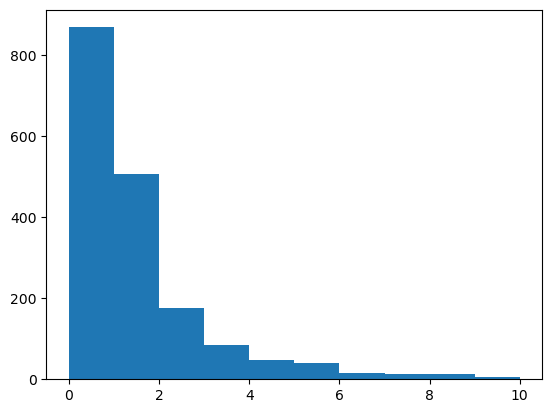

In [51]:
subdir = 'bushman_cafe'
X, y, label_encoder = load_task(data_dir, subdir, relative=True, filter_threshold=0.0)
plt.hist((X > 0).sum(axis=0), bins=10, range=(0, len(X)))
plt.show()